In [1]:
#coding=utf-8
import gdal
import os
import numpy as np
import argparse
from PIL import Image  
import cv2
import random
from tqdm import tqdm  
import time
import gdal
import seaborn as sns

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
# data for training  
from Models import *
from Models.SegNet2In import *
from Models.FCN32 import *
from Models.SegNet import *
from Models.utils import *
import argparse
import numpy as np 
from keras import backend as K 
from keras import *
from keras.applications import vgg16
from keras.layers import *
from keras.utils.np_utils import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.preprocessing.image import img_to_array
from keras.models import *
from keras import backend as K 
from sklearn.preprocessing import *
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
matplotlib.use("Agg")

D:\OneDrive\DL\Models\SegNet2In.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "c:\users\10151\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\10151\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\10151\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\10151\appdata\local\programs\python\python36\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "c:\users\10151\appdata\local\programs\python\pytho

D:\OneDrive\DL\Models\SegNet.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "c:\users\10151\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\10151\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\10151\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\10151\appdata\local\programs\python\python36\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "c:\users\10151\appdata\local\programs\python\python36

In [2]:
def plot_confusion_matrix(y_true, y_pred, labels):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    cmap = plt.cm.binary
    cm = confusion_matrix(y_true, y_pred)
    f, ax = plt.subplots(figsize=(6,5))
 
    sns.heatmap(cm, annot=True, ax=ax)
 
    print(cm)
    tick_marks = np.array(range(len(labels))) + 0.5
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8), dpi=120)
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array)
    intFlag = 0 # 标记在图片中对文字是整数型还是浮点型
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        #

        if (intFlag):
            c = cm[y_val][x_val]
            plt.text(x_val, y_val, "%d" % (c,), color='red', fontsize=18, va='center', ha='center')

        else:
            c = cm[y_val][x_val]
            if (c > 0.01):
                #这里是绘制数字，可以对数字大小和颜色进行修改
                plt.text(x_val, y_val, "%d" % (c,), color='red', fontsize=10, va='center', ha='center')
            else:
                plt.text(x_val, y_val, "%d" % (0,), color='red', fontsize=10, va='center', ha='center')
    if(intFlag):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    else:
        plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.title('')
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('Index of True Classes')
    plt.xlabel('Index of Predict Classes')
    #plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

In [3]:
def predict(key,stride=256):
    method = {
              'SegNet0': SegNet0}
    print("[INFO] loading network model...")
    try:
        model = load_model('D:\Python\seg-data/model/%s_model.h5' % key)
    except:
        model = method[key]() # 有自定义层时，不能直接加载模型
        model.load_weights('D:\Python\seg-data/model/%s_model.h5' % key)
    print('[INFO] model loaded')
    model.summary()
    image_size=stride
    TEST_SET=['2017']
    predir=r'D:\Python\seg-data\data_MB/'
    for n in range(len(TEST_SET)):
        tif_img = gdal.Open(predir+TEST_SET[n]+'.tif')
        tif_w = tif_img.RasterXSize #栅格矩阵的列数
        tif_h = tif_img.RasterYSize
        tif_data=tif_img.ReadAsArray(0,0,tif_w,tif_h)
        tif_d=tif_data.shape[0]
        tif_data=np.array(tif_data, dtype=float)
        image=cv2.merge(tif_data)
        h,w,_ = image.shape
        padding_h = (h//stride + 1) * stride 
        padding_w = (w//stride + 1) * stride
        padding_img = np.zeros((padding_h,padding_w,_))
        padding_img[0:h,0:w,:] = image[:,:,:]
        b1,b2,b3,b4=cv2.split(padding_img) 
        mask_whole = np.zeros((padding_h,padding_w))
        for i in range(padding_h//stride):
            for j in range(padding_w//stride):
                crop = padding_img[i*stride:i*stride+image_size,j*stride:j*stride+image_size,:]
                ch,cw,_ = crop.shape
                #print(i,j)
                if (ch != 256 or cw != 256):
                    print ('invalid size!')
                    continue
                #plt.imshow(crop[:, :,0]/crop.max(), cmap='gray')
                #plt.show()
                crop = np.expand_dims(crop, axis=0)
                try:
#########                    
                    layer_1 = K.function([model.layers[0].input], [model.layers[20].output])
                    f1 = layer_1([crop])[-1]
                    for _ in range(32):
                        show_img = f1[:, :, :, _]
                        show_img.shape = [32, 32]
                        plt.rcParams['figure.dpi'] = 200
                        plt.subplot(8, 4, _ + 1)
                        plt.imshow(show_img[0], cmap='gray')
                        print (show_img[0].shape)
                        plt.axis('off')
                    plt.show()
########                    
                    
                    pred = model.predict_classes(crop,verbose=0)
                    pred_prob = model.predict_proba(crop,verbose=1)#print ('trying\n')
                except AttributeError as e:
                   
                    pred = model.predict(crop)
                    pred=np.argmax(pred,axis=2).astype(np.float) 
                    #print ('AttributeError\n')
                pred = pred.reshape(256,256)
                mask_whole[i*stride:i*stride+image_size,j*stride:j*stride+image_size] = pred[:,:]
                cv2.imwrite('./pre-img/pre'+str(i+1)+"-"+str(j+1)+'.png',pred*255)
        cv2.imwrite('.pre-img/pre'+str(n+1)+'.png',mask_whole[0:h,0:w]*255)
    y_true=cv2.imread('D:\Python\seg-data\data_MB/' + TEST_SET[0]+'.png',cv2.IMREAD_GRAYSCALE)
    #print(y_true.flatten().shape,mask_whole[0:h,0:w].flatten().shape)
    plot_confusion_matrix(y_true.flatten(), mask_whole[0:h,0:w].flatten(),[ 0,1])
    plt.imshow(mask_whole,cmap='gray')

[INFO] loading network model...
[INFO] model loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      2368      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
batch_normalization_3 (B

conv2d_26 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_26 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 256, 256, 2)       130       
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 65536)          0         
_________________________________________________________________
permute_1 (Permute)          (None, 65536, 2)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 65536, 2)          0         
Total params: 31,821,442
Trainable params: 31,804,546
Non-trainable params: 16,896
_________________________________________________________________


TypeError: Invalid dimensions for image data

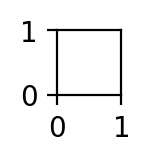

In [4]:
%matplotlib inline
predict(key='SegNet0',stride=256)